In [1]:
from data_loader import DataGenerator
from datetime import datetime
from model import lstm_builder
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        ModelCheckpoint, TensorBoard)
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import clear_session
import numpy as np
import warnings
from config import (model_config, data_generator_config, load_from_file,
                    n_epochs, model_name, tb_logs_path, model_checkpoint_file, test_seq_path)
from tensorflow.keras.losses import MSE, MAE
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics.pairwise import euclidean_distances
np.set_printoptions(suppress=True)
n_batches = 1000

In [2]:
def get_err_of_model(model, X, err_f, shape):
    preds = model.predict(X)
    errs = err_f(X.reshape(shape), preds.reshape(shape))
    err_of_mods = []
    for i, m_ix in enumerate(modifs_idx):
        if m_ix.shape[0] > 3 and m_ix.shape[0] < 50:
            err_of_mods.append(err_f(X[i, m_ix].flatten(),
                                     preds[i, m_ix].flatten()))
    overall_err_med = np.median(errs)
    overall_err_mean = np.mean(errs)
    mods_err_med = np.median(err_of_mods)
    mods_err_mean = np.mean(err_of_mods)
    return {"err (med, mean)": (overall_err_med, overall_err_mean), 
            "modifications_err (med, mean)": (mods_err_med, mods_err_mean)}

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def get_roll_mses(mse):
    roll_mses = []
    for idx in rolling_window(np.arange(mse.shape[0]), 4):
        roll_mses.append(np.median(mse))
    return np.array(roll_mses)

def get_y(X, preds, mses, threshold):
    y_true = []
    y_pred = []
    for sample, pred, mse in tqdm(zip(X, preds, mses)):
        if np.where(mse > threshold):
            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred

In [3]:
data_generator_config['quality_threshold'] = 19.5
data_generator_config['test'] = True
data_generator_config['seq_path'] = test_seq_path
data_generator_config['load2ram'] = False
data_generator_config['step_len'] = 64
data_generator_config['smooth_w_size'] = 7


# data_generator_config['motifs'] = ["CCAGG", "CCTGG", "GATC"]
data_generator_config

{'sample_len': 512,
 'batch_size': 1000,
 'quality_threshold': 19.5,
 'normalize': 'MEDIAN',
 'random_sample': True,
 'step_len': 64,
 'load2ram': False,
 'test': True,
 'smooth_w_size': 7,
 'seq_path': '/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5'}

In [4]:
data_loader = DataGenerator(**data_generator_config)

/tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/*.fast5


In [232]:
X = []
modifs_idx = []
modifs_type = []
for _ in tqdm(range(n_batches)):
    x, m_idx, type_ = next(data_loader)
    X.append(x)
    modifs_idx.append(m_idx)
    modifs_type.append(type_)

 14%|█▍        | 142/1000 [02:37<15:22,  1.08s/it]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160809_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_2_08_07_16_80510_ch180_read404_strand.fast5


 52%|█████▏    | 521/1000 [09:32<07:33,  1.06it/s]

unable to open file /tf/puc19/nanopore/MAP_Data/08_07_16_R9_pUC_BC/MA/downloads/pass/NB08/makeson_PC_20160807_FNFAD20242_MN17284_sequencing_run_MA_470_R9_pUC_g_PCR_BC_08_07_16_93165_ch432_read1037_strand.fast5


100%|██████████| 1000/1000 [18:14<00:00,  1.09s/it]


In [233]:
# import pickle
# with open("evaluation_data_7.pickle", "wb") as f:
#     pickle.dump(X, f)
#     pickle.dump(modifs_idx, f)
#     pickle.dump(modifs_type, f)

In [5]:
import pickle
with open("evaluation_data_7.pickle","rb") as f:
    X = pickle.load(f)
    modifs_idx = pickle.load(f)
    modifs_type = pickle.load(f)

In [6]:
X = np.array(X).reshape(n_batches*data_loader.batch_size, 
                        data_loader.sample_len, 1)
shape_ = (n_batches*data_loader.batch_size, data_loader.sample_len)
modifs_idx = np.array(modifs_idx).reshape(shape_[0])
modifs_type = np.array(modifs_type).reshape(shape_[0])
modifs_idx = modifs_idx.flatten()

In [7]:
# from tensorflow.keras import layers
# clear_session()
# model_lstm = load_model(r"2202/lstm.h5", custom_objects={'ELU': layers.ELU})

In [8]:
# from notify_run import Notify
# from tensorflow.keras import layers

# notify = Notify()
# notify.register()

In [9]:
clear_session()
from tensorflow.keras import layers
model_lstm = load_model(r"smoothed/unet.h5", custom_objects={'ELU': layers.ELU})
def mse(y_true, y_pred, ax=1):
    mses = ((y_true - y_pred)**2).mean(-1)
    return mses

def mae(y_true, y_pred, ax=1):
    return np.sum(np.absolute(y_true - y_pred), axis=ax)

# mse_str = f"mse: {get_err_of_model(model_lstm, X, mse, shape_)}"
# mae_str = f"mae: {get_err_of_model(model_lstm, X, mae, shape_)}"

# print(mse_str)
# print(mae_str)
# notify.send(mse_str)
# notify.send(mae_str)


In [10]:
preds = model_lstm.predict(X)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("mae: ", mean_absolute_error(X.reshape(shape_), preds.reshape(shape_)))
print("mse: ", mean_squared_error(X.reshape(shape_), preds.reshape(shape_)))

mae:  0.04018196896234111
mse:  0.002820521575957706


In [12]:
err_of_mods = []
for i, m_ix in enumerate(modifs_idx):
    if m_ix.shape[0] > 3 and m_ix.shape[0] < 50:
        err_of_mods.append(mean_absolute_error(X[i, m_ix].flatten(), preds[i, m_ix].flatten()))

In [13]:
np.mean(err_of_mods)

0.05752205540729135

In [14]:
preds_lstm = preds
X_shaped = X.reshape(shape_)
preds_shaped = preds_lstm.reshape(shape_)

In [15]:
now = datetime.now()
model_lstm.predict(X[:1000])
print("pred speed _lstm: ", datetime.now() - now)

pred speed _lstm:  0:00:01.784285


In [16]:
with_modif = np.array([i for i, ix in enumerate(modifs_idx) if 3 < len(ix) < 50])
without_modif = np.array([i for i, ix in enumerate(modifs_idx) if not len(ix)])
print(with_modif.shape)
print(without_modif.shape)

(251520,)
(739507,)


In [17]:
without_modif = without_modif[::2]

In [18]:
X_cropped = X[:, 100:-100]
preds_cropped_lstm = preds_shaped[:, 100:-100]

In [19]:
with_modif_in_middle = []
modif_in_middle_type = []
for ix in with_modif:
    if modifs_idx[ix][0] > 200 and modifs_idx[ix][-1] < 312:
        modif_in_middle_type.append(np.unique(modifs_type[ix].flatten()))
        with_modif_in_middle.append(ix)
with_modif_in_middle = np.array(with_modif_in_middle)

In [20]:
X_cropped = X_cropped.reshape(X_cropped.shape[0], X_cropped.shape[1])


mae_lstm = np.sum(np.absolute(X_cropped - preds_cropped_lstm), axis=1)
mses_lstm = ((X_cropped - preds_cropped_lstm)**2).mean(axis=1)

from scipy.spatial.distance import euclidean

euc_dist = np.empty_like(mae_lstm)
for i, (x, y) in enumerate(zip(X_cropped, preds_cropped_lstm)):
    euc_dist[i] = euclidean(x, y)
# notify.send(f"done: {euc_dist.shape}")
# euclidean = [euclidean_distances(X_cropped, preds_cropped_lstm)]

In [21]:
print(np.mean(mses_lstm[without_modif]))
print(np.mean(mses_lstm[with_modif]))
# print(np.mean(mae_lstm))

0.002519676739130028
0.003223798071337125


In [22]:
without_modif_set = set(without_modif)
with_modif_in_middle_set = set(with_modif_in_middle)
if len(without_modif_set.intersection(set(with_modif_in_middle))):
    raise ValueError("hmm")

In [23]:
np.median(mses_lstm[without_modif]) / np.median(mses_lstm[with_modif_in_middle])

0.699899541899521

In [24]:
ix2motif = {v: k for k, v in data_loader.motifs_map.items()}

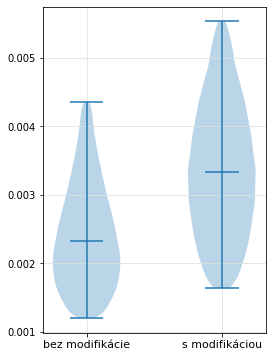

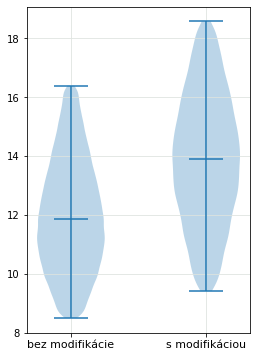

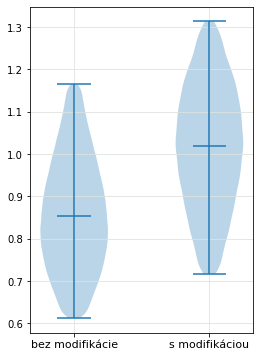

In [25]:
avg_mse_with_lstm = mses_lstm[with_modif_in_middle]
avg_mse_without_lstm = mses_lstm[without_modif]

p_min_without_lstm = np.percentile(avg_mse_without_lstm, 5)
p_max_without_lstm = np.percentile(avg_mse_without_lstm, 95)
p_min_with_lstm = np.percentile(avg_mse_with_lstm, 5)
p_max_with_lstm = np.percentile(avg_mse_with_lstm, 95)
without_lstm_avg = avg_mse_without_lstm[(avg_mse_without_lstm > p_min_without_lstm) 
                              & (avg_mse_without_lstm < p_max_without_lstm)]
with_lstm_avg = avg_mse_with_lstm[(avg_mse_with_lstm > p_min_with_lstm) 
                              & (avg_mse_with_lstm < p_max_with_lstm)]

plots = [without_lstm_avg, with_lstm_avg]
labels = ['bez modifikácie', "s modifikáciou"]

plt.figure(figsize=(4, 6))
plt.violinplot(plots, showmedians=True, positions=list(range(1, 3)))
plt.xticks([1, 2], labels=labels, fontsize=11)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_avg_lstm.png')

avg_mse_with_lstm = mae_lstm[with_modif_in_middle]
avg_mse_without_lstm = mae_lstm[without_modif]

p_min_without_lstm = np.percentile(avg_mse_without_lstm, 5)
p_max_without_lstm = np.percentile(avg_mse_without_lstm, 95)
p_min_with_lstm = np.percentile(avg_mse_with_lstm, 5)
p_max_with_lstm = np.percentile(avg_mse_with_lstm, 95)
without_lstm_avg = avg_mse_without_lstm[(avg_mse_without_lstm > p_min_without_lstm) 
                              & (avg_mse_without_lstm < p_max_without_lstm)]
with_lstm_avg = avg_mse_with_lstm[(avg_mse_with_lstm > p_min_with_lstm) 
                              & (avg_mse_with_lstm < p_max_with_lstm)]

plots = [without_lstm_avg, with_lstm_avg]
labels = ['bez modifikácie', "s modifikáciou"]

plt.figure(figsize=(4, 6))
plt.violinplot(plots, showmedians=True, positions=list(range(1, 3)))
plt.xticks([1, 2], labels=labels, fontsize=11)
plt.grid(color='#dee3df')

avg_mse_with_lstm = euc_dist[with_modif_in_middle]
avg_mse_without_lstm = euc_dist[without_modif]

p_min_without_lstm = np.percentile(avg_mse_without_lstm, 5)
p_max_without_lstm = np.percentile(avg_mse_without_lstm, 95)
p_min_with_lstm = np.percentile(avg_mse_with_lstm, 5)
p_max_with_lstm = np.percentile(avg_mse_with_lstm, 95)
without_lstm_avg = avg_mse_without_lstm[(avg_mse_without_lstm > p_min_without_lstm) 
                              & (avg_mse_without_lstm < p_max_without_lstm)]
with_lstm_avg = avg_mse_with_lstm[(avg_mse_with_lstm > p_min_with_lstm) 
                              & (avg_mse_with_lstm < p_max_with_lstm)]

plots = [without_lstm_avg, with_lstm_avg]
labels = ['bez modifikácie', "s modifikáciou"]

plt.figure(figsize=(4, 6))
plt.violinplot(plots, showmedians=True, positions=list(range(1, 3)))
plt.xticks([1, 2], labels=labels, fontsize=11)
plt.grid(color='#dee3df')

plt.show()



In [26]:
len([i for i in range(1, len(set(unq)) + 3)])

NameError: name 'unq' is not defined

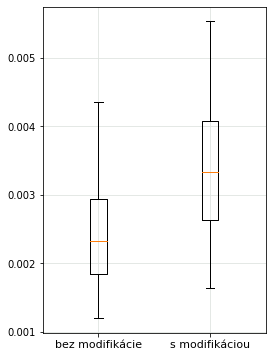

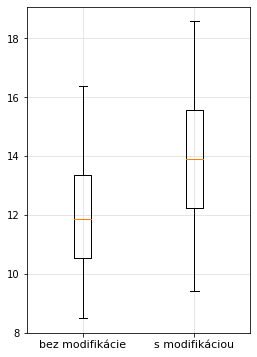

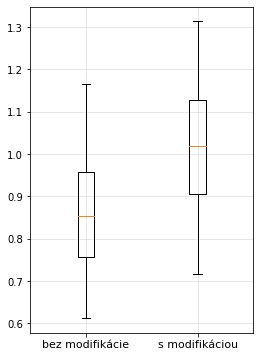

In [27]:
avg_mse_with_lstm = mses_lstm[with_modif_in_middle]
avg_mse_without_lstm = mses_lstm[without_modif]

p_min_without_lstm = np.percentile(avg_mse_without_lstm, 5)
p_max_without_lstm = np.percentile(avg_mse_without_lstm, 95)
p_min_with_lstm = np.percentile(avg_mse_with_lstm, 5)
p_max_with_lstm = np.percentile(avg_mse_with_lstm, 95)
without_lstm_avg = avg_mse_without_lstm[(avg_mse_without_lstm > p_min_without_lstm) 
                              & (avg_mse_without_lstm < p_max_without_lstm)]
with_lstm_avg = avg_mse_with_lstm[(avg_mse_with_lstm > p_min_with_lstm) 
                              & (avg_mse_with_lstm < p_max_with_lstm)]

plots = [without_lstm_avg, with_lstm_avg]
labels = ['bez modifikácie', "s modifikáciou"]

plt.figure(figsize=(4, 6))
plt.boxplot(plots, positions=list(range(1, 3)))
plt.xticks([1, 2], labels=labels, fontsize=11)
plt.grid(color='#dee3df')
# plt.savefig('violinplots_avg_lstm.png')

avg_mse_with_lstm = mae_lstm[with_modif_in_middle]
avg_mse_without_lstm = mae_lstm[without_modif]

p_min_without_lstm = np.percentile(avg_mse_without_lstm, 5)
p_max_without_lstm = np.percentile(avg_mse_without_lstm, 95)
p_min_with_lstm = np.percentile(avg_mse_with_lstm, 5)
p_max_with_lstm = np.percentile(avg_mse_with_lstm, 95)
without_lstm_avg = avg_mse_without_lstm[(avg_mse_without_lstm > p_min_without_lstm) 
                              & (avg_mse_without_lstm < p_max_without_lstm)]
with_lstm_avg = avg_mse_with_lstm[(avg_mse_with_lstm > p_min_with_lstm) 
                              & (avg_mse_with_lstm < p_max_with_lstm)]

plots = [without_lstm_avg, with_lstm_avg]
labels = ['bez modifikácie', "s modifikáciou"]

plt.figure(figsize=(4, 6))
plt.boxplot(plots, positions=list(range(1, 3)))
plt.xticks([1, 2], labels=labels, fontsize=11)
plt.grid(color='#dee3df')

avg_mse_with_lstm = euc_dist[with_modif_in_middle]
avg_mse_without_lstm = euc_dist[without_modif]

p_min_without_lstm = np.percentile(avg_mse_without_lstm, 5)
p_max_without_lstm = np.percentile(avg_mse_without_lstm, 95)
p_min_with_lstm = np.percentile(avg_mse_with_lstm, 5)
p_max_with_lstm = np.percentile(avg_mse_with_lstm, 95)
without_lstm_avg = avg_mse_without_lstm[(avg_mse_without_lstm > p_min_without_lstm) 
                              & (avg_mse_without_lstm < p_max_without_lstm)]
with_lstm_avg = avg_mse_with_lstm[(avg_mse_with_lstm > p_min_with_lstm) 
                              & (avg_mse_with_lstm < p_max_with_lstm)]

plots = [without_lstm_avg, with_lstm_avg]
labels = ['bez modifikácie', "s modifikáciou"]

plt.figure(figsize=(4, 6))
plt.boxplot(plots, positions=list(range(1, 3)))
plt.xticks([1, 2], labels=labels, fontsize=11)
plt.grid(color='#dee3df')

plt.show()



In [28]:
np.median(without_lstm_avg) / np.median(with_lstm_avg)

0.8365999891813733

In [96]:
thr = np.percentile(euc_dist[without_modif], 75)
print(len(with_modif_in_middle))
np.where(euc_dist[with_modif_in_middle] > thr)[0].shape


2699


(1821,)

In [26]:
import os
from datetime import datetime
os.cpu_count()

40

In [31]:
mses = ((X_cropped - preds_cropped_lstm)**2)
train_mses = mses[without_modif]
test_mses = mses[with_modif_in_middle]

In [32]:
train_mses

array([[0.00003654, 0.00002527, 0.00002913, ..., 0.00240157, 0.00172555,
        0.0014035 ],
       [0.00080543, 0.001151  , 0.00105504, ..., 0.00282423, 0.00232999,
        0.00213665],
       [0.00896624, 0.00946945, 0.00945288, ..., 0.00577994, 0.00023917,
        0.00367314],
       ...,
       [0.00211696, 0.00309456, 0.00366904, ..., 0.00014715, 0.00039624,
        0.0005839 ],
       [0.000005  , 0.00000776, 0.00002454, ..., 0.00008965, 0.00030589,
        0.00015085],
       [0.00025154, 0.0002384 , 0.00028418, ..., 0.00004923, 0.00002908,
        0.00003422]])

In [33]:
def axis1_wrapper(f, x):
    return f(x, axis=-1)

In [34]:
from collections import Counter
def percentile1(x, axis=1):
    return np.percentile(x, 25, axis=axis)
def percentile2(x, axis=1):
    return np.percentile(x, 75, axis=axis)
def num_higher_mean(x, axis=1):
    means = x.mean(1)
    nums = np.array([np.where(xx > mean_)[0].shape[0]
                     for xx, mean_ in zip(x, means)])
    return nums

In [35]:
os.cpu_count()

NameError: name 'os' is not defined

In [36]:
functions = [np.mean, np.median, np.ptp, percentile1,
             percentile2, np.std, np.var, np.argmax, np.argmin,
             np.max, np.min, np.sum, np.prod, num_higher_mean]

In [37]:
train_columns = []
test_columns = []
for f in tqdm(functions):
    train_columns.append(axis1_wrapper(f, train_mses))
    test_columns.append(axis1_wrapper(f, test_mses))
X = np.column_stack(train_columns)
X_test = np.column_stack(test_columns)

100%|██████████| 14/14 [00:08<00:00,  1.62it/s]


In [38]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X, test_size=0.2, shuffle=True, random_state=1)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

import pickle

with open("X_unet.pickle","wb") as f:
    pickle.dump(scaler, f)
    pickle.dump(X_train, f)
    pickle.dump(X_val, f)
    pickle.dump(X_test, f)

# idx = np.random.randint(0, X.shape[0], 320000)
# now = datetime.now()
# clf = make_pipeline(Normalizer(), OneClassSVM(gamma='auto'))
# clf = OneClassSVM(cache_size=128000)
# clf = IsolationForest(n_jobs=32)
# clf.fit(X[idx])
# print(datetime.now() - now)